In [5]:
import numpy as np
import sys
import pandas as pd
from scipy import optimize
sys.path.append("../")
sys.path.append("../processing")
sys.path.append("../mappings")
from run_processing import convert_top_level_dir_to_dataframe, load_measurement
from tune_waveform_modeling import get_channel_data

In [6]:
input_dir = "../scanData/raw/APA_5947a8b0-5152-11ed-84c6-9170f34dd09b_apa4_dwa5/"
raw_df = convert_top_level_dir_to_dataframe(input_dir)
raw_df

,datetime,layer,side,headboard_num,json_path,scan_id
0,2023-02-08 14:35:07,U,B,7,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T143507_U_B_7_138-140-142-144-146-148-...
1,2023-02-08 18:31:04,U,A,8,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T183104_U_A_8_97-99-101-103-105-107-10...
2,2023-02-08 15:32:55,X,B,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T153255_X_B_4_145-147-149-151-153-155-...
3,2023-02-08 17:27:37,U,A,3,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T172737_U_A_3_298-300-302-304-306-308-...
4,2023-02-08 13:27:01,X,B,9,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T132701_X_B_9_418-420-422-424-426-428-...
...,...,...,...,...,...,...
283,2023-02-08 13:26:26,X,B,9,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T132626_X_B_9_402-404-406-408-410-412-...
284,2023-02-08 15:33:12,X,B,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T153312_X_B_4_146-148-150-152-154-156-...
285,2023-02-08 17:36:24,U,A,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T173624_U_A_4_242-244-246-248-250-252-...
286,2023-02-08 14:06:42,X,B,8,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T140642_X_B_8_369-371-373-375-377-379-...


In [7]:
dwa_channel = 0
scan_dict = load_measurement(raw_df, raw_df.loc[42, "scan_id"])

layer = scan_dict["layer"]
apa_channel = scan_dict["apa_channels"][dwa_channel]
channel_dict = scan_dict[apa_channel]

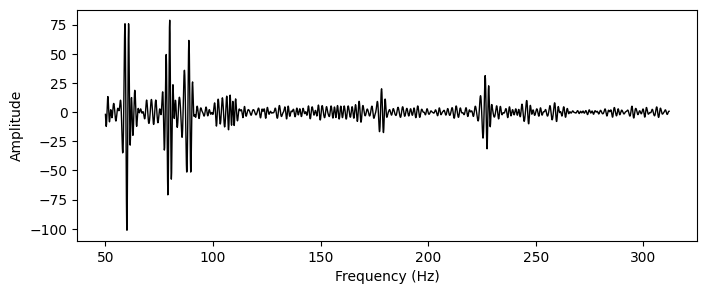

In [8]:
from importlib import reload
import plotting
import matplotlib.pyplot as plt

reload(plotting)

plotting.plot_channel(channel_dict, figsize=(8, 3), color="k", lw=1, show_expectation=False)
# make output dir if it doesn't exist
import os
if not os.path.exists("plots_output"):
    os.makedirs("plots_output")
plt.savefig("plots_output/example_scan.pdf", bbox_inches="tight")

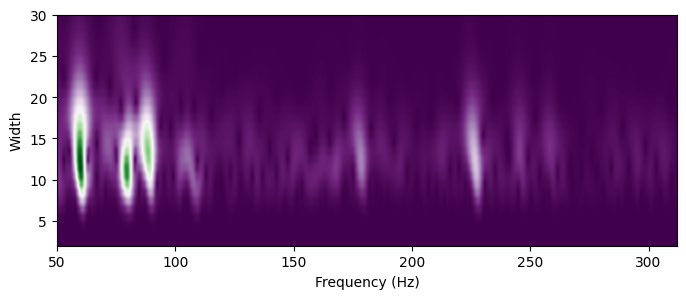

In [9]:
reload(plotting)
ax = plotting.plot_channel_cwt_matr(channel_dict, widths=(2, 30), figsize=(8, 3), show_cbar=True)
plt.savefig("plots_output/example_scan_cwt.pdf", bbox_inches="tight")

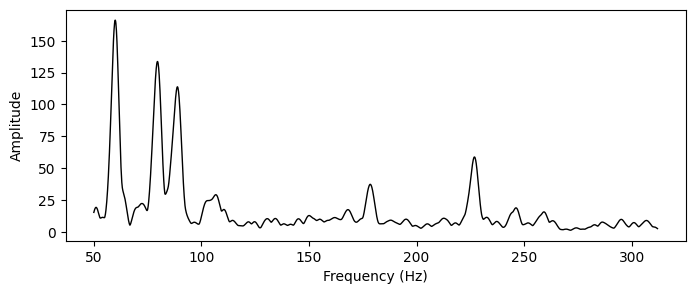

In [10]:
reload(plotting)
plotting.plot_channel_cwt(
    channel_dict,
    scan_dict["layer"],
    widths=(8, 16),
    side=scan_dict["side"],
    figsize=(8, 3),
    color="k",
    lw=1,
)
plt.savefig("plots_output/example_scan_cwt_avg.pdf", bbox_inches="tight")

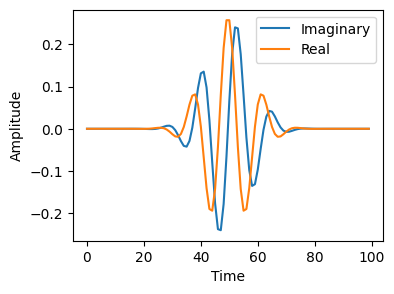

In [11]:
from scipy import signal

M = 100
s = 8.0
w = 4.0
wavelet = signal.morlet2(M, s, w)
plt.figure(figsize=(4, 3))
# plot the imaginary part of the wavelet
plt.plot(wavelet.imag, label="Imaginary")
# plot the real part of the wavelet
plt.plot(wavelet.real, label="Real")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.savefig("plots_output/morlet_wavelet.pdf", bbox_inches="tight")

In [56]:
import tension_algorithm_v2 as ta
from scipy.optimize import nnls

def get_channel_cwt(channel_dict):
    algo = ta.TensionAlgorithmV2(0)
    freq = channel_dict["freq"]
    ampl = algo.cumsum_and_baseline_subtracted(freq, channel_dict["ampl"])
    corr_amplitude = algo._transform_cwt_amplitude(ampl, widths=(8, 16))
    return corr_amplitude

channel_cwt = get_channel_cwt(channel_dict)
freq = channel_dict["freq"]
subsample = 4
channel_cwt = channel_cwt[::subsample]
freq = freq[::subsample]

max_freq = 200
freq = freq[freq < max_freq]
channel_cwt = channel_cwt[:len(freq)]

algo = ta.TensionAlgorithmV2(0)
template_locations = np.arange(len(channel_cwt))
scale, dof = 16.25 / subsample, 2.2
weights, residual = algo._deconvolve_resonances(channel_cwt, scale, template_locations, dof)
reconvolved = algo._reconvolve_resonances(freq, weights, template_locations, scale , dof)

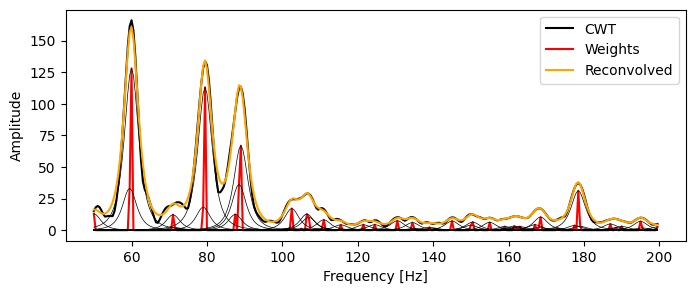

In [64]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(freq, channel_cwt, label="CWT", color="k")
ax.plot(freq, weights, label="Weights", color="r")
ax.plot(freq, reconvolved, label="Reconvolved", color="orange")
nonzero_locations = freq[weights > 0]
delta_freq = freq[1] - freq[0]
# plot template at every location where the weight is nonzero
for loc, weight in zip(nonzero_locations, weights[weights > 0]):
    ax.plot(freq, weight * (1 + (loc - freq)**2 / ((scale * delta_freq) ** 2 * dof))**(-0.5 * (1 + dof)), color="k", lw=0.5)
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude")
plt.savefig("plots_output/example_scan_cwt_deconvolve.pdf", bbox_inches="tight")

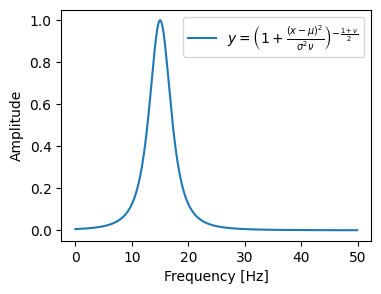

In [30]:
plot_freq = np.arange(400) * np.diff(freq)[0]
one_template = algo._reconvolve_resonances(
    plot_freq, np.array([1]), np.array([15 / np.diff(freq)[0]]), scale, dof
)
plt.figure(figsize=(4, 3))
plt.plot(plot_freq, one_template, label=r"$y = \left(1 + \frac{(x - \mu)^2}{\sigma^2 \nu}\right)^{-\frac{1+\nu}{2}}$")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")

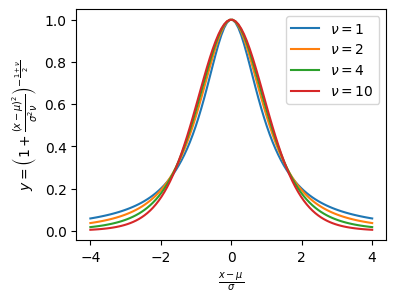

In [34]:
nu_arr = np.array([1, 2, 4, 10])
x_plot = np.linspace(-4, 4, 100)
plt.figure(figsize=(4, 3))
for nu in nu_arr:
    plt.plot(x_plot, (1 + x_plot**2 / nu)**(-0.5 * (1 + nu)), label=r"$\nu = {}$".format(nu))
plt.xlabel(r"$\frac{x - \mu}{\sigma}$")
plt.ylabel(r"$y = \left(1 + \frac{(x - \mu)^2}{\sigma^2 \nu}\right)^{-\frac{1+\nu}{2}}$")
plt.legend(loc="upper right")
plt.savefig("plots_output/t_distribution.pdf", bbox_inches="tight")